In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [2]:
from utils import *
from hash_utils import digest
from game_model import game
from rp_model import computeRP
from variables import *
from computed import computedColumns
from initial_guess import make_initial_guess


In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle('./data/rp-data.pickle')
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.000000,5465.0,5465.0,5465.0,5465.000000,5465.000000
mean,9.504483,558.335041,1.399634,558.326214,-0.008827,3999.432754,3863.991508,12.022507,28.004209,36.541812,108.899360,0.998525,0.989268,0.994979,1.001025,1.005672,0.206873,30.613036,53.119122,145.736139,1.0,0.0,0.0,0.989369,1.025429
std,6.251181,326.788079,0.898714,326.800586,0.795908,942.987550,1003.505055,3.315086,2.612509,6.863081,15.761472,0.291601,0.059411,0.045319,0.118243,0.118452,0.043644,32.873601,25.247767,54.726980,0.0,0.0,0.0,0.034974,0.066618
min,1.000000,245.000000,1.000000,245.050000,-9.450000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.980000,25.000000,90.000000,1.0,0.0,0.0,0.790000,1.000000
25%,5.000000,349.000000,1.000000,348.870000,-0.310000,3400.000000,3079.788000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,11.980000,35.000000,101.000000,1.0,0.0,0.0,1.000000,1.000000
50%,8.000000,436.000000,1.000000,436.080000,-0.050000,4000.000000,3853.200000,11.000000,28.000000,35.000000,103.000000,0.930000,1.000000,1.000000,1.000000,1.000000,0.200000,18.180000,43.000000,121.000000,1.0,0.0,0.0,1.000000,1.000000
75%,12.000000,663.000000,1.000000,662.910000,0.230000,4500.000000,4482.000000,14.000000,30.000000,40.000000,115.000000,1.160000,1.000000,1.000000,1.000000,1.000000,0.230000,43.060000,66.000000,202.000000,1.0,0.0,0.0,1.000000,1.000000
max,29.000000,3432.000000,6.000000,3431.840000,7.100000,6300.000000,6916.140000,23.000000,35.000000,67.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.380000,413.870000,195.000000,302.000000,1.0,0.0,0.0,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,8.0,531.0,Hardy,1,Questions help guides,530.68,-0.32,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.78,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,9.0,574.0,Naughty,1,Rate My Mon,574.38,0.38,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.78,538.38,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1,Questions help guides,538.05,0.05,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.78,530.63,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3,,957.93,-0.07,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.46,937.91,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2,pokemon sleep general,714.96,-0.04,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.16,750.12,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = computedColumns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return computeRP(x, data, computed, unpack_info)

def residual(x):
    return data["RP"] - RP(x)


In [7]:
filename = f"./results/linear-fit-{digest(data, x0)}.npy"
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.562e-01  2.545e-01 ...  2.196e-01  2.194e-01]
       cost: 814.695264281178
       grad: [-6.245e-07 -3.453e-05 ... -6.397e-05 -3.049e-05]
 optimality: 0.03631047531962395
       nfev: 58
       njev: 40

In [8]:
# What are the worst points ?

df = data[["Pokemon","ID","Level","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
336,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,19.0,6,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.626859,9.373141,87.855771
2150,Togekiss,TogekissGentle103Skill Trigger M,10.0,16.0,3,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.702293,9.297707,86.447360
358,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,19.0,3,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.306434,8.693566,75.578082
535,Charmeleon,CharmeleonQuiet252Inventory Up MSleep EXP Bonus,25.0,15.0,2,Ingredient Finding,Exp Gains,Inventory Up M,Sleep EXP Bonus,1063.0,1054.410957,8.589043,73.771659
1831,Raticate,RaticateBrave281Inventory Up MSleep EXP Bonus,28.0,16.0,1,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1097.0,1088.750306,8.249694,68.057446
272,Butterfree,ButterfreeImpish265Skill Level Up MSleep EXP B...,26.0,21.0,5,Energy Recovery,Ingredient Finding,Skill Level Up M,Sleep EXP Bonus,1404.0,1411.101808,-7.101808,50.435676
2058,Sudowoodo,SudowoodoHasty162Berry Finding S,16.0,10.0,2,EXP Gains,Energy Recovery,Berry Finding S,,743.0,750.017565,-7.017565,49.246216
1394,Leafeon,LeafeonRelaxed102Inventory Up M,10.0,13.0,2,Energy Recovery,EXP Gains,Inventory Up M,,944.0,937.179015,6.820985,46.525836
315,Butterfree,ButterfreeSassy102Helping bonus,10.0,21.0,2,Main Skill Chance,EXP Gains,Helping bonus,,816.0,809.202588,6.797412,46.204804
232,Butterfree,ButterfreeCareful103Berry Finding S,10.0,21.0,3,Main Skill Chance,Ingredient Finding,Berry Finding S,,910.0,903.356011,6.643989,44.142590


intercept,0.033163
intercept_stderr,0.0195513
pvalue,0.000561418
rvalue,-0.0466484
slope,-0.00593233
stderr,0.0017187


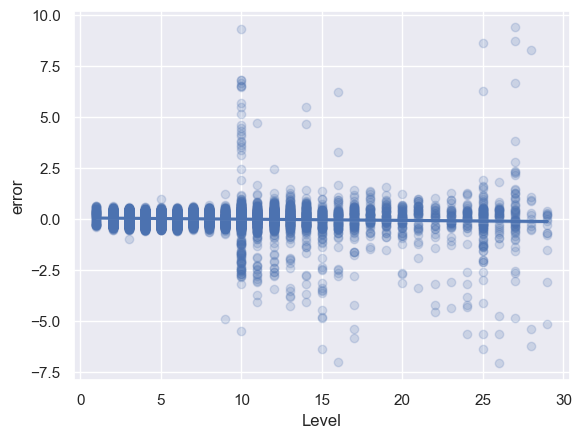

In [9]:
# Plot error vs level

err = df[["Level","error"]]
g = sns.regplot(data=err, x="Level", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,0.0371222
intercept_stderr,0.0169884
pvalue,8.65285e-06
rvalue,-0.068425
slope,-0.00882006
stderr,0.00198032


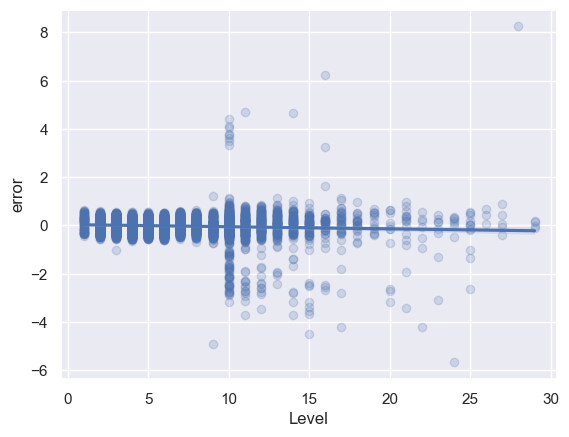

In [10]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error"]].loc[df["MS lvl"]==1]
g = sns.regplot(data=err, x="Level", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

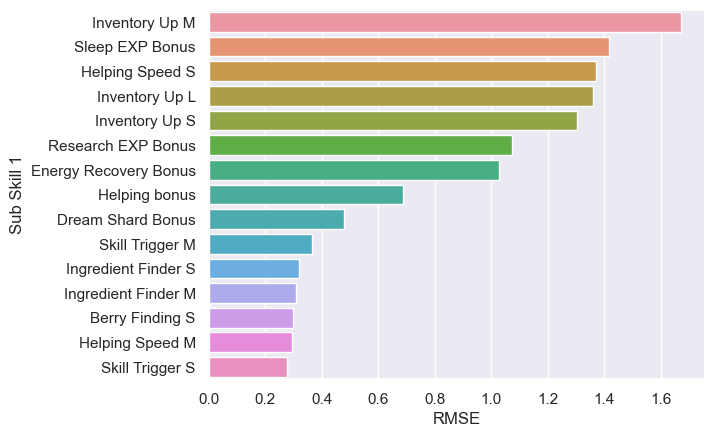

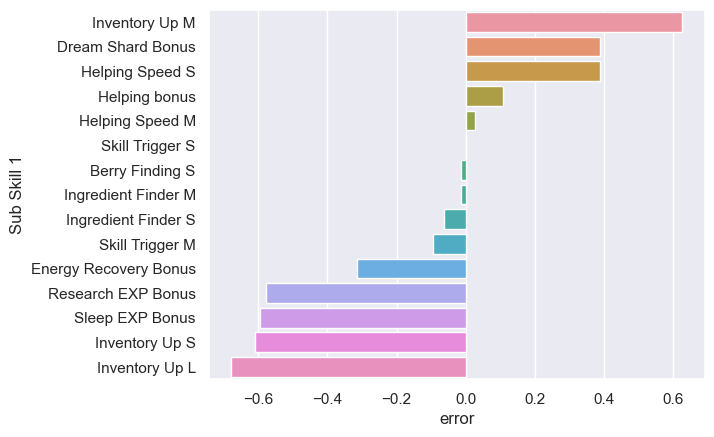

In [11]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')]

intercept,0.0371222
intercept_stderr,0.0169884
pvalue,8.65285e-06
rvalue,-0.068425
slope,-0.00882006
stderr,0.00198032


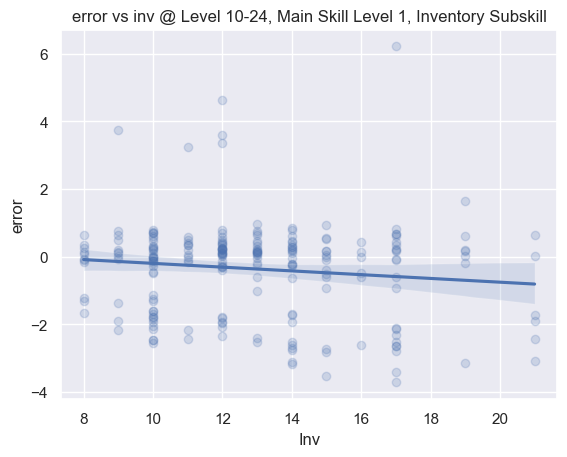

In [20]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"].str.contains("Inventory")) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')]

intercept,0.0371222
intercept_stderr,0.0169884
pvalue,8.65285e-06
rvalue,-0.068425
slope,-0.00882006
stderr,0.00198032


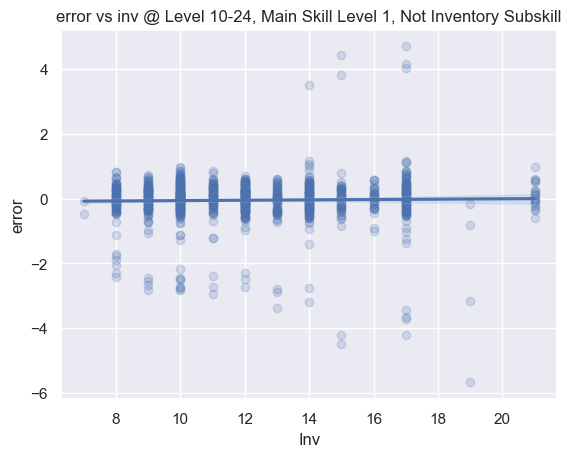

In [22]:
# Let's see what happens at level 10-24, main skill 1, and not inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]>9) & (df["Level"]<25) & (df["MS lvl"]==1) & ( ~df["Sub Skill 1"].str.contains("Inventory") ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

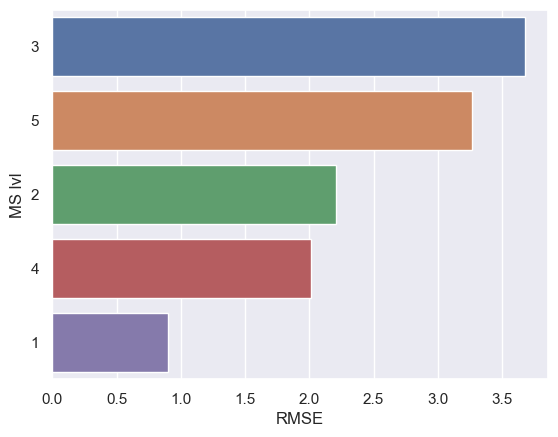

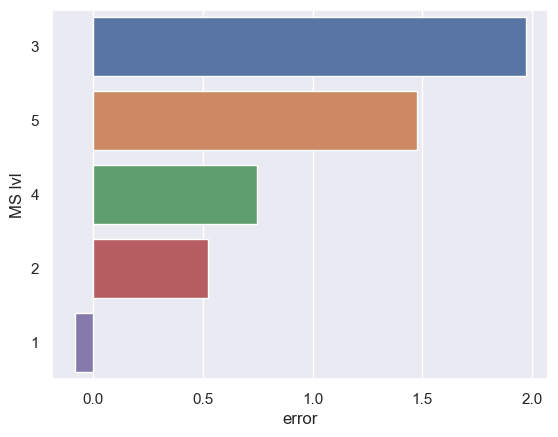

In [12]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


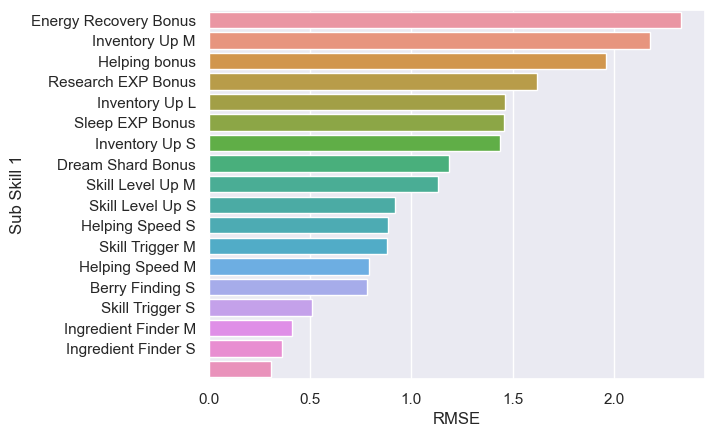

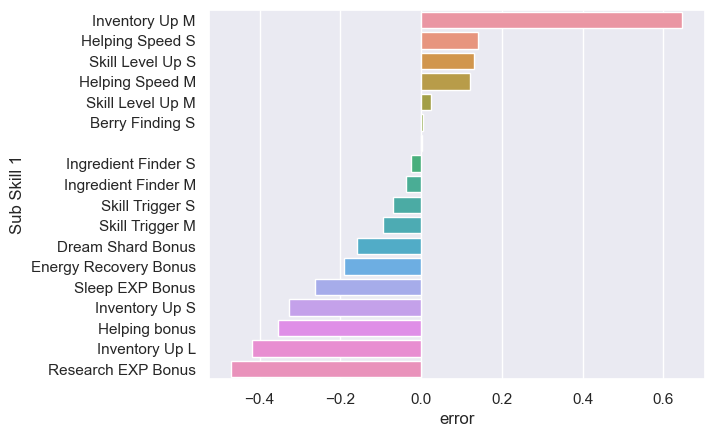

In [13]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

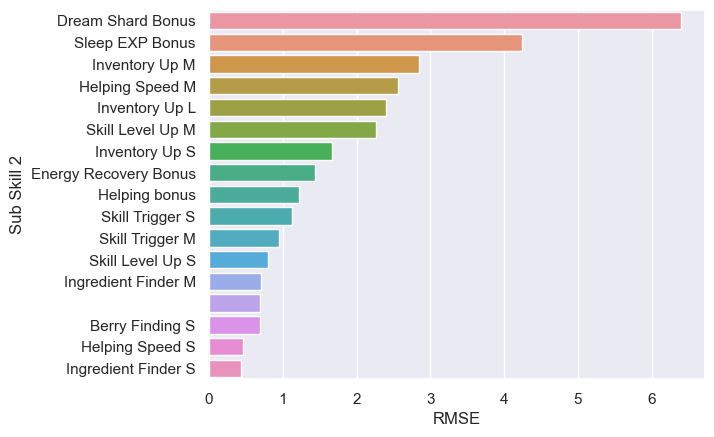

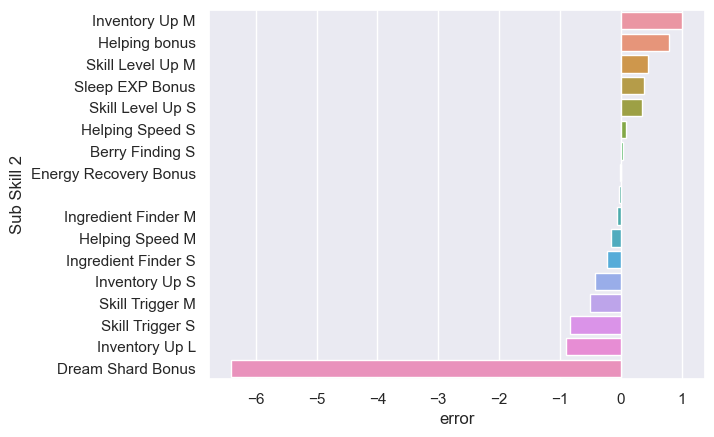

In [14]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")